# XGBoost hyperparameter tuning using Ax optimalization framework

Ax is an open-source package from PyTorch that helps you find a minima for any function over the range of parameters. One of the useful ML applications is to find the best hyperparameters for training a model to achieve minimal loss.

Sources:
- https://ax.dev/docs/core.html
- https://github.com/facebook/Ax/blob/master/tutorials/gpei_svm.ipynb
- https://xgboost.readthedocs.io/en/latest/parameter.html
- https://towardsdatascience.com/rocking-hyperparameter-tuning-with-pytorchs-ax-package-1c2dd79f2948

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load sample dataset

In [2]:
# load PIMA indians diabetes dataset
diabetes = pd.read_csv('pima-indians-diabetes.csv')

In [3]:
diabetes

,1. Number of times pregnant,2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test,3. Diastolic blood pressure (mm Hg),4. Triceps skin fold thickness (mm),5. 2-Hour serum insulin (mu U/ml),6. Body mass index (weight in kg/(height in m)^2),7. Diabetes pedigree function,8. Age (years),9. Class variable (0 or 1)
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


## Dataset pre-processing

In [4]:
# rename columns to short names
diabetes.columns = [
    "NumTimesPrg", "PlGlcConc", "BloodP",
    "SkinThick", "TwoHourSerIns", "BMI",
    "DiPedFunc", "Age", "HasDiabetes"]

In [5]:
# fill zero values with the mean of the column values
for col in ['PlGlcConc', 'BloodP', 'SkinThick', 'TwoHourSerIns', 'BMI']:
    median_val = diabetes[col].mean()
    diabetes[col] = diabetes[col].replace(to_replace=0, value=median_val)

In [6]:
y = diabetes["HasDiabetes"].copy()
X = diabetes.drop("HasDiabetes", axis=1)
print ('X shape:', X.shape, 'Y shape:', y.shape)

# split to train/test set
from sklearn.model_selection import train_test_split
X_train_pd, X_test_pd, y_train_pd, y_test_pd = train_test_split(X, y, test_size=0.1, random_state=42)

X_train = np.asarray(X_train_pd)
X_test = np.asarray(X_test_pd)
y_train = np.asarray(y_train_pd)
y_test = np.asarray(y_test_pd)

print ('X train shape:', X_train.shape, 'y train shape:', y_train.shape)

X shape: (768, 8) Y shape: (768,)
X train shape: (691, 8) y train shape: (691,)


## XGBoost binary classification with default values

In [7]:
# pip3 install xgboost

import xgboost as xgb
from sklearn.metrics import accuracy_score

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
print('test:', y_test)
print('predicted:', y_pred)
print('accuracy:', accuracy_score(y_test, y_pred))

test: [0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 1 0 1 1 1 1 0 1 1
 1 0 1 0 0 0 1 0 1 1 0 0 0 0 1 1 1 0 0 0 0 0 1 1 0 0 1 0 0 0 1 0 1 0 0 0 1
 0 0 0]
predicted: [1 0 0 0 1 1 0 1 1 1 0 1 0 1 0 1 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 1 1 1 1 1 1
 0 0 1 0 0 1 0 0 1 1 0 0 1 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 1 0 1 1 0 0 0
 0 0 0]
accuracy: 0.6753246753246753


## Use of Ax optimalization framework

In [8]:
# see: https://github.com/facebook/Ax/blob/master/tutorials/gpei_svm.ipynb

from ax import (
    ParameterType,
    RangeParameter,
    SearchSpace,
    SimpleExperiment,
    modelbridge,
    models
)

In [9]:
# The evaluation function takes in a parameterization (set of parameter values) 
# and computes all the metrics needed in optimization.
# It should output a dictionary of metric names to tuple of mean and standard error.

def xgb_evaluation_function(
    parameterization, # dict of parameter names to values of those parameters
    weight=None, # required by the evaluation function signature
):
    xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42,
                                  gamma=parameterization["gamma"],
                                  max_depth=parameterization["max_depth"],
                                  learning_rate=parameterization["learning_rate"],
                                  n_estimators=parameterization["n_estimators"],
                                  subsample=parameterization["subsample"],
                                  colsample_bytree=parameterization["colsample_bytree"]
                                 )
    
    # learn the model
    xgb_model.fit(X_train, y_train)
    # predict data
    y_pred = xgb_model.predict(X_test)   
    # diagnostics
    accuracy =  accuracy_score(y_test, y_pred)
    print('gamma:', parameterization["gamma"],
          'max_depth:', parameterization["max_depth"],
          'learning_rate:', parameterization["learning_rate"],
          'n_estimators:', parameterization["n_estimators"],
          'subsample:', parameterization["subsample"],
          'colsample_bytree:', parameterization["colsample_bytree"],          
          '--> accuracy:',accuracy)
    
    return {
        'accuracy': (accuracy, 0.0),
    }

In [10]:
# Define search space - set of input model parameters with allowed values

xgb_search_space = SearchSpace(parameters=[
    RangeParameter(
        name='gamma', parameter_type=ParameterType.FLOAT, lower=0.1, upper=0.5, log_scale=True
    ),
    RangeParameter(
        name='learning_rate', parameter_type=ParameterType.FLOAT, lower=0.02, upper=0.3, log_scale=True
    ),
    RangeParameter(
        name='max_depth', parameter_type=ParameterType.INT, lower=2, upper=6, log_scale=True
    ),
    RangeParameter(
        name='n_estimators', parameter_type=ParameterType.INT, lower=100, upper=150, log_scale=True
    ),
    RangeParameter(
        name='subsample', parameter_type=ParameterType.FLOAT, lower=0.4, upper=0.6, log_scale=True
    ),
    RangeParameter(
        name='colsample_bytree', parameter_type=ParameterType.FLOAT, lower=0.3, upper=0.7, log_scale=True
    )    
])

In [11]:
# SimpleExperiment can be used here instead of Experiment because points tried in optimization
# are computed synchrously via the evaluation function.

exp = SimpleExperiment(
    name='XGB_optimalization',
    search_space=xgb_search_space,
    evaluation_function=xgb_evaluation_function,
    objective_name='accuracy',
    minimize=False # maximize accuracy
)

In [12]:
# We only instantiate the Sobol generator once, as the underlying model does not to be re-fit every 
# time new data is added to the experiment.

sobol = modelbridge.get_sobol(search_space=exp.search_space)
print(f"Running Sobol initialization trials...")

for _ in range(5):
    exp.new_trial(generator_run=sobol.gen(1))

for i in range(15):
    print(f"Running GP+EI optimization trial {i+1}/15...")
    # Since we need to re-fit the underlying GP model, we reinstantiate the GP+EI model every
    # time new data is added to the experiment.
    gpei = modelbridge.get_GPEI(experiment=exp, data=exp.eval())
    exp.new_trial(generator_run=gpei.gen(1))

Running Sobol initialization trials...
Running GP+EI optimization trial 1/15...
gamma: 0.24192201429854296 max_depth: 2 learning_rate: 0.034374127992448746 n_estimators: 137 subsample: 0.4634753710993098 colsample_bytree: 0.6396296896746235 --> accuracy: 0.7402597402597403
gamma: 0.39246612968864075 max_depth: 3 learning_rate: 0.14399077413930483 n_estimators: 120 subsample: 0.41500192940769426 colsample_bytree: 0.4566586386838339 --> accuracy: 0.7272727272727273
gamma: 0.17563144419046975 max_depth: 5 learning_rate: 0.07200058843469385 n_estimators: 129 subsample: 0.537389370814471 colsample_bytree: 0.5600181996228627 --> accuracy: 0.7272727272727273
gamma: 0.22065934965478573 max_depth: 2 learning_rate: 0.07856150047257449 n_estimators: 109 subsample: 0.4304762690277365 colsample_bytree: 0.5038926243687332 --> accuracy: 0.7402597402597403
gamma: 0.49083644998947074 max_depth: 4 learning_rate: 0.04057286401937862 n_estimators: 143 subsample: 0.49225619410731036 colsample_bytree: 0.410

In [13]:
# We can inspect the evaluation data we observed and plot it:
dat = exp.eval()
dat.df

gamma: 0.2384916957558975 max_depth: 2 learning_rate: 0.035649522055299206 n_estimators: 135 subsample: 0.4637780492454511 colsample_bytree: 0.6425710886377622 --> accuracy: 0.7272727272727273


,arm_name,metric_name,mean,sem,trial_index
0,0_0,accuracy,0.740260,0.0,0
1,1_0,accuracy,0.727273,0.0,1
2,2_0,accuracy,0.727273,0.0,2
3,3_0,accuracy,0.740260,0.0,3
4,4_0,accuracy,0.714286,0.0,4
5,5_0,accuracy,0.727273,0.0,5
6,6_0,accuracy,0.714286,0.0,6
7,7_0,accuracy,0.727273,0.0,7
8,8_0,accuracy,0.714286,0.0,8
9,9_0,accuracy,0.714286,0.0,9


In [14]:
# Show used metrics for the experiment
print ('Used metrics:', exp.metrics)

# get best accuracy
best = dat.df.max()
print (best)

best_arm_name=best.arm_name
best_trial_index=best.trial_index
print ('trial_index:', best_trial_index, ', best_arm_name:', best_arm_name)

Used metrics: {'accuracy': Metric('accuracy')}
arm_name            9_0
metric_name    accuracy
mean            0.74026
sem                   0
trial_index          19
dtype: object
trial_index: 19 , best_arm_name: 9_0


In [15]:
# show arms
exp.arms_by_name[best_arm_name]

Arm(name='9_0', parameters={'gamma': 0.26487783393669123, 'learning_rate': 0.03427808182115059, 'max_depth': 2, 'n_estimators': 138, 'subsample': 0.4659983889191017, 'colsample_bytree': 0.6117900935859985})

In [16]:
# Use eval_trial function to get evaluation data for a specific trial in the experiment
trial_data = exp.eval_trial(exp.trials[best_trial_index])
trial_data.df

,arm_name,metric_name,mean,sem,trial_index
0,19_0,accuracy,0.727273,0.0,19


In [19]:
for arm in exp.trials[best_trial_index].arms:
    print(arm)

Arm(name='19_0', parameters={'gamma': 0.2384916957558975, 'learning_rate': 0.035649522055299206, 'max_depth': 2, 'n_estimators': 135, 'subsample': 0.4637780492454511, 'colsample_bytree': 0.6425710886377622})


In [20]:
from ax.plot.contour import plot_contour
from ax.utils.notebook.plotting import render, init_notebook_plotting

render(plot_contour(model=gpei, param_x='gamma', param_y='learning_rate', metric_name='accuracy', relative=False))

Snip:
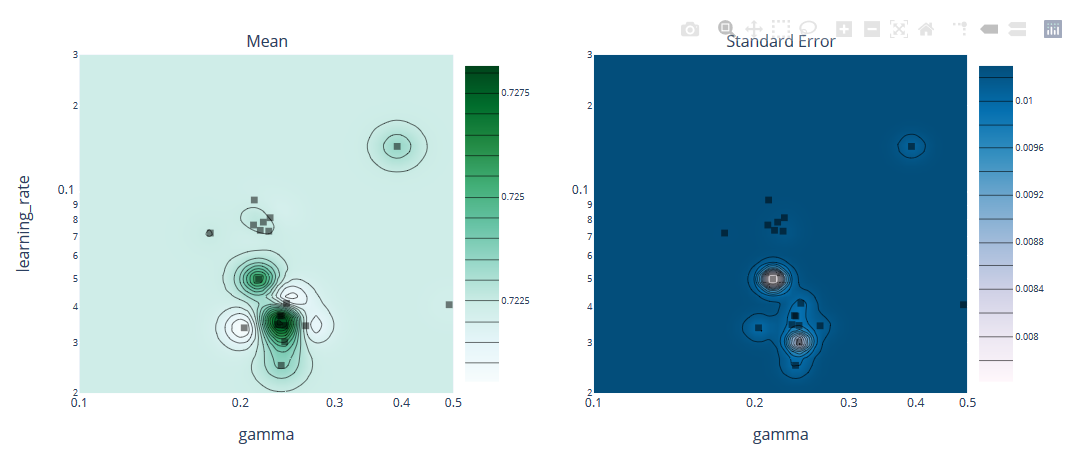